In [1]:
# from hmmlearn import hmm
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
# import pykovy-master/ 
from pykovy.src.pykovy import chain
import matplotlib.pyplot as plt
from time import time
import networkx as nx


In [2]:

# np.random.seed(42)

# model = hmm.GaussianHMM(n_components=3, covariance_type="full")
# model.startprob_ = np.array([0.6, 0.3, 0.1])
# model.transmat_ = np.array([[0.7, 0.2, 0.1],
#                             [0.3, 0.5, 0.2],
#                             [0.3, 0.3, 0.4]])
# model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
# model.covars_ = np.tile(np.identity(2), (3, 1, 1))
# X, Z = model.sample(100)

In [3]:
df = pd.read_csv('../all_data.csv')
df = df[['Client Username', 'Association Time', 'Map Location', 'Session Duration']]

In [4]:
# re-code userid
df['Client Username'] = pd.Categorical(df['Client Username'])
df['Client Username'] = df['Client Username'].cat.codes
# df = df.drop(['Client Username'], axis=1)

# recode map location
map_dict = {}
count = 0
for i in df['Map Location'].unique():
    map_dict[i] = count
    count += 1
df['Map Location'] = df['Map Location'].map(map_dict)

In [5]:
df

,Client Username,Association Time,Map Location,Session Duration
0,55029,Mon Jul 02 12:43:23 PDT 2018,0,3 hrs 31 min 53 sec
1,46470,Mon Jul 02 13:25:13 PDT 2018,1,2 hrs 36 min 28 sec
2,46470,Mon Jul 02 16:01:41 PDT 2018,1,10 min 11 sec
3,46470,Mon Jul 02 16:17:43 PDT 2018,1,49 sec
4,62338,Mon Jul 02 11:15:04 PDT 2018,2,5 min 9 sec
5,62338,Mon Jul 02 11:25:19 PDT 2018,2,5 min 5 sec
6,62338,Mon Jul 02 11:30:26 PDT 2018,3,5 min 6 sec
7,62338,Mon Jul 02 11:35:33 PDT 2018,4,5 min 7 sec
8,62338,Mon Jul 02 13:14:58 PDT 2018,5,5 min 10 sec
9,62338,Mon Jul 02 13:20:09 PDT 2018,6,5 min 3 sec


In [6]:
def timer(func):
    # this part is for timer ignore
    def wrapper(*arg):
        before = time()
        rv = func(*arg)
        after = time()
        print('Elapsed: ', after-before)
        return rv
    return wrapper

def convertMonth(month):
    if month == 'Jan': return 1
    elif month == 'Feb': return 2
    elif month == 'Mar': return 3
    elif month == 'Apr': return 4
    elif month == 'May': return 5
    elif month == 'Jun': return 6
    elif month == 'Jul': return 7
    elif month == 'Aug': return 8
    elif month == 'Sep': return 9
    elif month == 'Oct': return 10
    elif month == 'Nov': return 11
    elif month == 'Dec': return 12
    else: print('error input is not correct')
        
def convert_to_timeslot(duration):
    temp = duration.split()
    if len(temp) == 2: sess_duration = int(temp[0])
    elif len(temp) == 4: sess_duration = int(temp[0]) * 60 + int(temp[2])
    elif len(temp) == 6: sess_duration = (int(temp[0]) * 60 + int(temp[2])) * 60 + int(temp[4])
    else: print('error')
    return datetime.timedelta(seconds=sess_duration)

def convert_to_datetime(time):
    temp = time.split()
    d_time = datetime.datetime(year=int(temp[5]), month=convertMonth(temp[1]), day=int(temp[2]), hour=int(temp[3].split(':')[0]), minute=int(temp[3].split(':')[1]), second=int(temp[3].split(':')[2]))
    return d_time

# data_list has same number of row as df.
# Each row [userid, map_loc, associate_time, associate_time+sess_dur, sess_dur].
def create_data_list(df):
    data_list = []
    c=0
    for i in range(df.shape[0]):
        if c%500000 == 0:
            print(c)
        sess = convert_to_timeslot(df.iloc[i,3])
        s_time = convert_to_datetime(df.iloc[i,1])
        e_time = s_time + sess
        data_list.append([df.iloc[i,0], df.iloc[i,2], s_time, e_time, sess])
        c+=1
        
    data_list = sorted(data_list, key=lambda element: (element[0], element[2]))
    return data_list

# add up the session duration when the previous row has the same userid and location. 
# (this happen when you disconnect from the ap and reconnect again or your wifi session expire, etc.)
def preprocess_data_list(df, data_list):
    for i in reversed(range(1, df.shape[0])):
        if data_list[i][0] == data_list[i-1][0] and data_list[i][1] == data_list[i-1][1]: #and data_list[i][2] - data_list[i-1][3] <= timedelta(hours=5):
            data_list[i-1][4] += data_list[i][4]

    # loop each row, remove the next concecutive rows has the same userid and map_loc with the current row.
    # Because they are useless now
    final_data_list = []
    i = 0
    while i < df.shape[0]-1:
        if data_list[i][0] == data_list[i+1][0] and data_list[i][1] == data_list[i+1][1]:
            final_data_list.append(data_list[i])
            c = 2
            while i+c <= df.shape[0]-1 and data_list[i][0] == data_list[i+c][0] and data_list[i][1] == data_list[i+c][1]:
                c += 1
            i += c

        else:
            final_data_list.append(data_list[i])
            i += 1

    if not (final_data_list[-1][0] == data_list[-1][0] and final_data_list[-1][1] == data_list[-1][1]):
        final_data_list.append(data_list[-1])

    return final_data_list


# user_dict's key are each userid and value is a list of all rows of each user in final_data_list
def create_user_dict(final_data_list):
    user_dict = defaultdict(list)
    for row in final_data_list:
        user_dict[row[0]].append([row[2], row[1], row[4]])
        
#     for usr in user_dict:
#         user_dict[usr].sort()

    return user_dict

def remove_jitter(final_data_list):
    pass

@timer
def preprocess_and_create_user_dict(df):
    data_list = create_data_list(df)
    final_data_list = preprocess_data_list(df, data_list)
    print(len(final_data_list), len(data_list))
#     final_data_list = remove_jitter(final_data_list)
    print(len(final_data_list), len(data_list))
    user_dict = create_user_dict(final_data_list)
    return user_dict


In [7]:
user_dict = preprocess_and_create_user_dict(df)

0
500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
2380449 6114987
2380449 6114987
Elapsed:  339.6233298778534


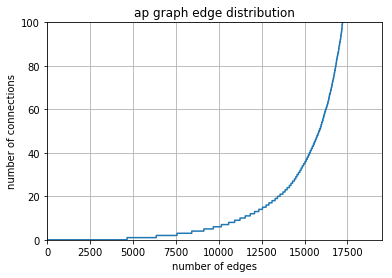

In [8]:
# make an 198x198 graph (198 is the number of aps) this is the graph of the school, 
# the edges are how many connections in total that all students have traveled.
def create_198_198_map(df, user_dict, draw=True):
    num_aps = len(df["Map Location"].unique())
    undir_map = np.zeros(39204, dtype=np.int32).reshape(198, 198)
    for usr in user_dict:
        for i in range(len(user_dict[usr])-1):
            if user_dict[usr][i][1] != user_dict[usr][i+1][1]:
                undir_map[user_dict[usr][i][1]][user_dict[usr][i+1][1]] += 1
                undir_map[user_dict[usr][i+1][1]][user_dict[usr][i][1]] += 1

    
    # draw the number of connections each edge is used. Change ax.set_ylim([0, 75]) to scale the graph
    # try to find the edges that are bad (low connections, too high connections) and prune them
    if draw:
        draw_list = []
        c = 0
        for i in range(len(undir_map)):
            c+=1
            for j in range(len(undir_map[i])-c):
                draw_list.append(undir_map[i][j+c])
        draw_list.sort()
        # Data for plotting
        x = np.arange(0,len(draw_list))

        _, ax = plt.subplots()
        ax.set_xlim([0, len(draw_list)])
        ax.set_ylim([0, 100])
        ax.plot(x, draw_list)
        ax.set(xlabel='number of edges', ylabel='number of connections',
               title='ap graph edge distribution')
        ax.grid()
        # fig.savefig("test.png")
        plt.show()
    
    return undir_map

undir_map = create_198_198_map(df, user_dict)

In [9]:
def map_pruning(undir_map, low=50, high=5000):
    size = len(undir_map)
    undir_map1 = np.zeros(size**2, dtype=np.int32).reshape(size, size)

    for i in range(size):
        for j in range(size):
            if undir_map[i][j] >=low and undir_map[i][j] <=high:
                undir_map1[i][j] = 1
            else: undir_map1[i][j] = 0

    return undir_map1

undir_map_prune = map_pruning(undir_map, low=50, high=5000)


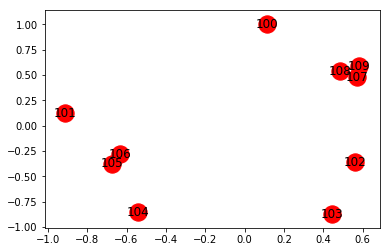

In [10]:
def create_nx_graph(undir_map_prune):
    nx_graph = nx.to_networkx_graph(undir_map_prune)
    res = np.arange(100, 110)
    # nx.draw_networkx(nx_graph, nodelist=res, node_size=[6])
    # pos = nx.spring_layout(nx_graph)  #setting the positions with respect to G, not k.
    k = nx_graph.subgraph(res)

    nx.draw_networkx(k)
    return nx_graph

nx_graph = create_nx_graph(undir_map_prune)
# find all the paths from 2 nodes with length of 3 or less
paths = nx.algorithms.simple_paths.all_simple_paths(nx_graph, 3, 5, cutoff= 3)

In [11]:
def create_freq_dict(user_dict):
    # time spend on each ap during the entire dataset for each user
    ap_freq_dict = defaultdict(dict)
    total_time_each_usr = {}
    for usr in user_dict:
        for i in range(len(user_dict[usr])): 
            ap_freq_dict[usr][user_dict[usr][i][1]] = datetime.timedelta(0)
            total_time_each_usr[usr] = datetime.timedelta(0)

    for usr in user_dict:
        for i in range(len(user_dict[usr])):
            ap_freq_dict[usr][user_dict[usr][i][1]] += user_dict[usr][i][2]
            total_time_each_usr[usr] += user_dict[usr][i][2]
    
    return ap_freq_dict, total_time_each_usr

ap_freq_dict, _ = create_freq_dict(user_dict)

In [12]:
ap_freq_dict[1]

{8: datetime.timedelta(days=1, seconds=4438),
 22: datetime.timedelta(seconds=1514),
 31: datetime.timedelta(seconds=2154),
 0: datetime.timedelta(seconds=10551),
 9: datetime.timedelta(seconds=306),
 7: datetime.timedelta(seconds=301),
 55: datetime.timedelta(seconds=305)}